In [1]:
import sys
sys.path.insert(0, '../')

import torch

from data.audioLoader import AudioLoader
from data.trainDataset import TrainDataset
from ganSystem import GANSystem
import logging

# logging.getLogger().setLevel(logging.DEBUG)  # set root logger to debug

"""Just so logging works..."""
formatter = logging.Formatter('%(name)s:%(levelname)s:%(message)s')
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)
console_handler.setFormatter(formatter)
logging.getLogger().addHandler(console_handler)
"""Just so logging works..."""

__author__ = 'Andres'

signal_split = [480, 64, 480]
md = 32

params_stft_discriminator = dict()
params_stft_discriminator['stride'] = [2, 2, 2, 2, 2]
params_stft_discriminator['nfilter'] = [md, 2 * md, 4 * md, 8 * md, 16 * md]
params_stft_discriminator['shape'] = [[5, 5], [5, 5], [5, 5], [5, 5], [5, 5]]
params_stft_discriminator['data_size'] = 2

params_mel_discriminator = dict()
params_mel_discriminator['stride'] = [2, 2, 2, 2, 2]
params_mel_discriminator['nfilter'] = [md//4, 2 * md//4, 4 * md//4, 8 * md//4, 16 * md//4]
params_mel_discriminator['shape'] = [[5, 5], [5, 5], [5, 5], [5, 5], [5, 5]]
params_mel_discriminator['data_size'] = 2

params_generator = dict()
params_generator['stride'] = [2, 2, 2, 2, 2]
params_generator['nfilter'] = [8 * md, 4 * md, 2 * md, md, 1]
params_generator['shape'] = [[4, 4], [4, 4], [8, 8], [8, 8], [8, 8]]
params_generator['padding'] = [[1, 1], [1, 1], [3, 3], [3, 3], [3, 3]]
params_generator['residual_blocks'] = 2

params_generator['full'] = 256 * md
params_generator['summary'] = True
params_generator['data_size'] = 2
params_generator['in_conv_shape'] = [16, 2]
params_generator['borders'] = dict()
params_generator['borders']['nfilter'] = [md, 2 * md, md, md / 2]
params_generator['borders']['shape'] = [[5, 5], [5, 5], [5, 5], [5, 5]]
params_generator['borders']['stride'] = [2, 2, 2, 2]
params_generator['borders']['data_size'] = 2
params_generator['borders']['border_scale'] = 1
# This does not work because of flipping, border 2 need to be flipped tf.reverse(l, axis=[1]), ask Nathanael
params_generator['borders']['width_full'] = None

# Optimization parameters inspired from 'Self-Attention Generative Adversarial Networks'
# - Spectral normalization GEN DISC
# - Batch norm GEN
# - TTUR ('GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium')
# - ADAM  beta1=0 beta2=0.9, disc lr 0.0004, gen lr 0.0001
# - Hinge loss
# Parameters are similar to the ones in those papers...
# - 'PROGRESSIVE GROWING OF GANS FOR IMPROVED QUALITY, STABILITY, AND VARIATION'
# - 'LARGE SCALE GAN TRAINING FOR HIGH FIDELITY NATURAL IMAGE SYNTHESIS'
# - 'CGANS WITH PROJECTION DISCRIMINATOR'

params_optimization = dict()
params_optimization['batch_size'] = 64
params_stft_discriminator['batch_size'] = 64
params_mel_discriminator['batch_size'] = 64

params_optimization['n_critic'] = 1
params_optimization['generator'] = dict()
params_optimization['generator']['optimizer'] = 'adam'
params_optimization['generator']['kwargs'] = [0.5, 0.9]
params_optimization['generator']['learning_rate'] = 1e-4
params_optimization['discriminator'] = dict()
params_optimization['discriminator']['optimizer'] = 'adam'
params_optimization['discriminator']['kwargs'] = [0.5, 0.9]
params_optimization['discriminator']['learning_rate'] = 1e-4

# all parameters
params = dict()
params['net'] = dict()  # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['stft_discriminator'] = params_stft_discriminator
params['net']['mel_discriminator'] = params_mel_discriminator
params['net']['prior_distribution'] = 'gaussian'
params['net']['shape'] = [1, 512, 1024]  # Shape of the image
params['net']['inpainting'] = dict()
params['net']['inpainting']['split'] = signal_split
params['net']['gamma_gp'] = 10  # Gradient penalty
# params['net']['fs'] = 16000//downscale
params['net']['loss_type'] = 'wasserstein'

params['optimization'] = params_optimization
params['summary_every'] = 250  # Tensorboard summaries every ** iterations
params['print_every'] = 50  # Console summaries every ** iterations
params['save_every'] = 1000  # Save the model every ** iterations
# params['summary_dir'] = os.path.join(global_path, name +'_summary/')
# params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')

args = dict()
args['generator'] = params_generator
args['stft_discriminator_count'] = 2
args['mel_discriminator_count'] = 3
args['stft_discriminator'] = params_stft_discriminator
args['mel_discriminator'] = params_mel_discriminator
args['borderEncoder'] = params_generator['borders']
args['stft_discriminator_in_shape'] = [1, 512, 64]
args['mel_discriminator_in_shape'] = [1, 80, 64]
args['mel_discriminator_start_powscale'] = 2
args['generator_input'] = 1440
args['optimizer'] = params_optimization
args['split'] = signal_split
args['log_interval'] = 100
args['spectrogram_shape'] = params['net']['shape']
args['gamma_gp'] = params['net']['gamma_gp']
args['tensorboard_interval'] = 500
args['save_path'] = '../saved_results/'
args['experiment_name'] = 'real_data'
args['save_interval'] = 10000

args['fft_length'] = 1024
args['fft_hop_size'] = 256
args['sampling_rate'] = 22050

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

examples_per_file = 32
audioLoader = AudioLoader(args['sampling_rate'], args['fft_length'], args['fft_hop_size'], 50)

dataFolder = "../../../../Datasets/maestro-v2.0.0/"

ganSystem = GANSystem(args)


/home/amarafioti/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/amarafioti/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/amarafioti/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/amarafioti/.local/lib/python3.7/site-packages/tensor

In [2]:
start_at_step = 400000
start_at_epoch = 1

ganSystem.loadModel(start_at_step, start_at_epoch)

In [3]:
from data.audioLoader import AudioLoader
from data.validDataset import ValidDataset


examples_per_file=1
validDataset = ValidDataset(dataFolder, window_size=1024, audio_loader=audioLoader, examples_per_file=examples_per_file, loaded_files_buffer=20, file_usages=1)

valid_loader = torch.utils.data.DataLoader(validDataset,
    batch_size=args['optimizer']['batch_size']//examples_per_file, shuffle=False,
                                           num_workers=0, drop_last=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for data in valid_loader:
    print('loaded')
    spectrograms=data[0]
    audios = data[1]
    
    audios = audios.view(args['optimizer']['batch_size'], -1)
    
    spectrograms = spectrograms.to(device).float()
    spectrograms = spectrograms.view(args['optimizer']['batch_size'], *args['spectrogram_shape'])

    left_borders = spectrograms[:, :, :, :args['split'][0]]
    right_borders = spectrograms[:, :, :, args['split'][0] + args['split'][1]:]
    print('generate')
    generated_spectrograms = ganSystem.generateGap([left_borders, right_borders])

    fake_spectrograms = torch.cat((left_borders, generated_spectrograms, right_borders), 3)
    break

loaded
generate


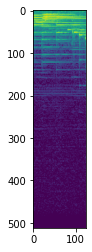

In [4]:
import matplotlib.pyplot as plt

plt.imshow(fake_spectrograms[2, 0, :,  450:-450].detach().cpu())

In [5]:
from tifresi.stft import GaussTruncTF, GaussTF
from tifresi.transforms import inv_log_spectrogram, log_spectrogram
import numpy as np

stft = GaussTruncTF(256, 1024)
fake_audios = np.zeros([len(audios), fake_spectrograms.shape[-1]*args['fft_hop_size']])

for index, (real_audio, spectrogram) in enumerate(zip(audios, fake_spectrograms)):
    unprocessed_spectrogram = inv_log_spectrogram((spectrogram-1)*25).squeeze().detach().cpu()
    unprocessed_spectrogram = np.concatenate([unprocessed_spectrogram,
                                  np.zeros_like(unprocessed_spectrogram)[0:1, :]], axis=0) # Fill last column of freqs with zeros    
    audio = stft.invert_spectrogram(unprocessed_spectrogram)
    fake_audios[index] = audio


In [ ]:
plt.imshow(np.log(np.clip(unprocessed_spectrogram, a_min=1e-5, a_max=None)))


In [ ]:
from IPython.display import display, Audio

for generated_audio_signal in fake_audios:
    display(Audio(generated_audio_signal[int(len(generated_audio_signal)*0.3):], rate=22050))

# Prepare and save data for the experiments

In [ ]:
import os 
import numpy as np
import librosa 
from pydub import AudioSegment

from tifresi.phase.modGabPhaseGrad import modgabphasegrad
from tifresi.phase.pghi_masked import pghi
from tifresi.stft import GaussTruncTF, GaussTF

def match_target_amplitude(sound, target_dBFS=-24):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

def saveAudioForlisteningTest(audio, path):
    resampled_sound = librosa.core.resample(audio, args['sampling_rate'], 48000)
    shifted_sound = (resampled_sound * (2 ** 31 - 1)).astype(np.int32)
    sound = AudioSegment(shifted_sound.tobytes(),
                         frame_rate=48000,
                         sample_width=4, #  4 bytes, so 32 bit sample
                         channels=1)     #  mono
    sound = sound.fade_in(500)
    sound = sound.fade_out(500)

    normalized_sound = match_target_amplitude(sound)
    normalized_sound.export(path, format='wav')
    

hop_size = 256
stft_channels = 1024
stft = GaussTruncTF(256, 1024)

base_folder_name = "maestro-recordings/"
os.mkdir(base_folder_name)

real_folder = base_folder_name + 'real/'
fake_folder = base_folder_name + "GAN/"
clicked_folder = base_folder_name + "clicked/"
pghi_folder = base_folder_name + "pghi/"

os.mkdir(real_folder)
os.mkdir(fake_folder)
os.mkdir(clicked_folder)
os.mkdir(pghi_folder)


for index, (real_audio, fake_audio) in enumerate(zip(audios, fake_audios)): 
    start = 480*256 - int((np.random.rand()*2+2) * 22050)
    end = 544*256 + int((np.random.rand()*2+2) * 22050)
    
    #Real
    real = real_audio[start:end].detach().cpu().numpy().copy()    
    saveAudioForlisteningTest(real, real_folder + str(index) + '.wav')

    #Clicked
    audio_to_save = real_audio.detach().cpu().numpy().copy()
    audio_to_save = audio_to_save / np.max(np.abs(audio_to_save)) / 2
    audio_to_save[480*256:482*256] += np.sin(2*np.pi*440*np.arange(0,2*256)/22050) / 2
    audio_to_save = audio_to_save[start:end]

    saveAudioForlisteningTest(audio_to_save, clicked_folder + str(index) + '.wav')

    #Fake
    saveAudioForlisteningTest(fake_audio[start:end], fake_folder + str(index) + '.wav')
   
    #PGHI
    dgt = stft.dgt(real_audio.detach().cpu().numpy().copy())
    spectrogram = np.abs(dgt)
    mask = np.ones_like(spectrogram)
    mask[:, 480:480+64] = 0
    
    tfr = hop_size * stft_channels / len(real_audio.detach().cpu().numpy())
    g_analysis = {'name': 'gauss', 'tfr': tfr}
    
    tgrad, fgrad = modgabphasegrad('abs', spectrogram, g_analysis, hop_size,
                                       stft_channels)
    
    phase, _ = pghi(spectrogram, tgrad, fgrad, hop_size, stft_channels, len(real_audio.detach().cpu().numpy()), mask, phase=np.angle(dgt))
    
    reComplexStft = spectrogram * np.exp(1.0j * phase)

    audio = stft.idgt(reComplexStft, hop_size, stft_channels)

    saveAudioForlisteningTest(audio[start:end], pghi_folder + str(index) + '.wav')
